In [6]:
import os

import numpy as np
import pandas as pd
from scipy.io import loadmat, wavfile

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(context='talk')

from tqdm import tqdm_notebook as tqdm

import librosa

# Build Overview DataFrame

In [2]:
speaker_info = {'03': ('m', 31), '08': ('f', 34), '09': ('f', 21), '10': ('m', 32), '11': ('m', 26),
                '12': ('m', 30), '13': ('f', 32), '14': ('f', 35), '15': ('m', 25), '16': ('f', 31)}
emotion_map = {'A': 'fear', 'E': 'disgust', 'W': 'anger', 'L': 'boredom', 
               'F': 'happiness', 'N': 'neutral', 'T': 'sadness'}

In [3]:
df = pd.read_csv('./EmoDB/erkennung.txt',sep='\t',encoding='Latin1',index_col=0)
exists = []

df.Satz = df.Satz.apply(lambda x: x.split('.')[0])
df.erkannt = df.erkannt.apply(lambda x: int(x.split(',')[0]))
df.natuerlich = df.natuerlich.apply(lambda x: int(x.split(',')[0]))
df['sex'] = df.Satz.apply(lambda x: speaker_info[x[:2]][0])
df['age'] = df.Satz.apply(lambda x: speaker_info[x[:2]][1])
df['emotion'] = df.Satz.apply(lambda x: emotion_map[x[5]])

for index,row in tqdm(df.iterrows()):    
    if os.path.exists('./EmoDB/wav/%s.wav'%row.Satz):
        exists.append(True)
    else: # wave-file not found
        exists.append(False)

df['wav_available'] = exists
df = df.rename(index=str, columns={'erkannt': 'recognized', 'natuerlich': 'natural'})
df = df.set_index('Satz')
df.head()

,recognized,natural,sex,age,emotion,wav_available
Satz,,,,,,
03a01Ab,65,35,m,31,fear,False
03a01Eb,60,35,m,31,disgust,False
03a01Fa,90,75,m,31,happiness,True
03a01Lb,70,35,m,31,boredom,False
03a01Nc,100,95,m,31,neutral,True


# EDA - meta

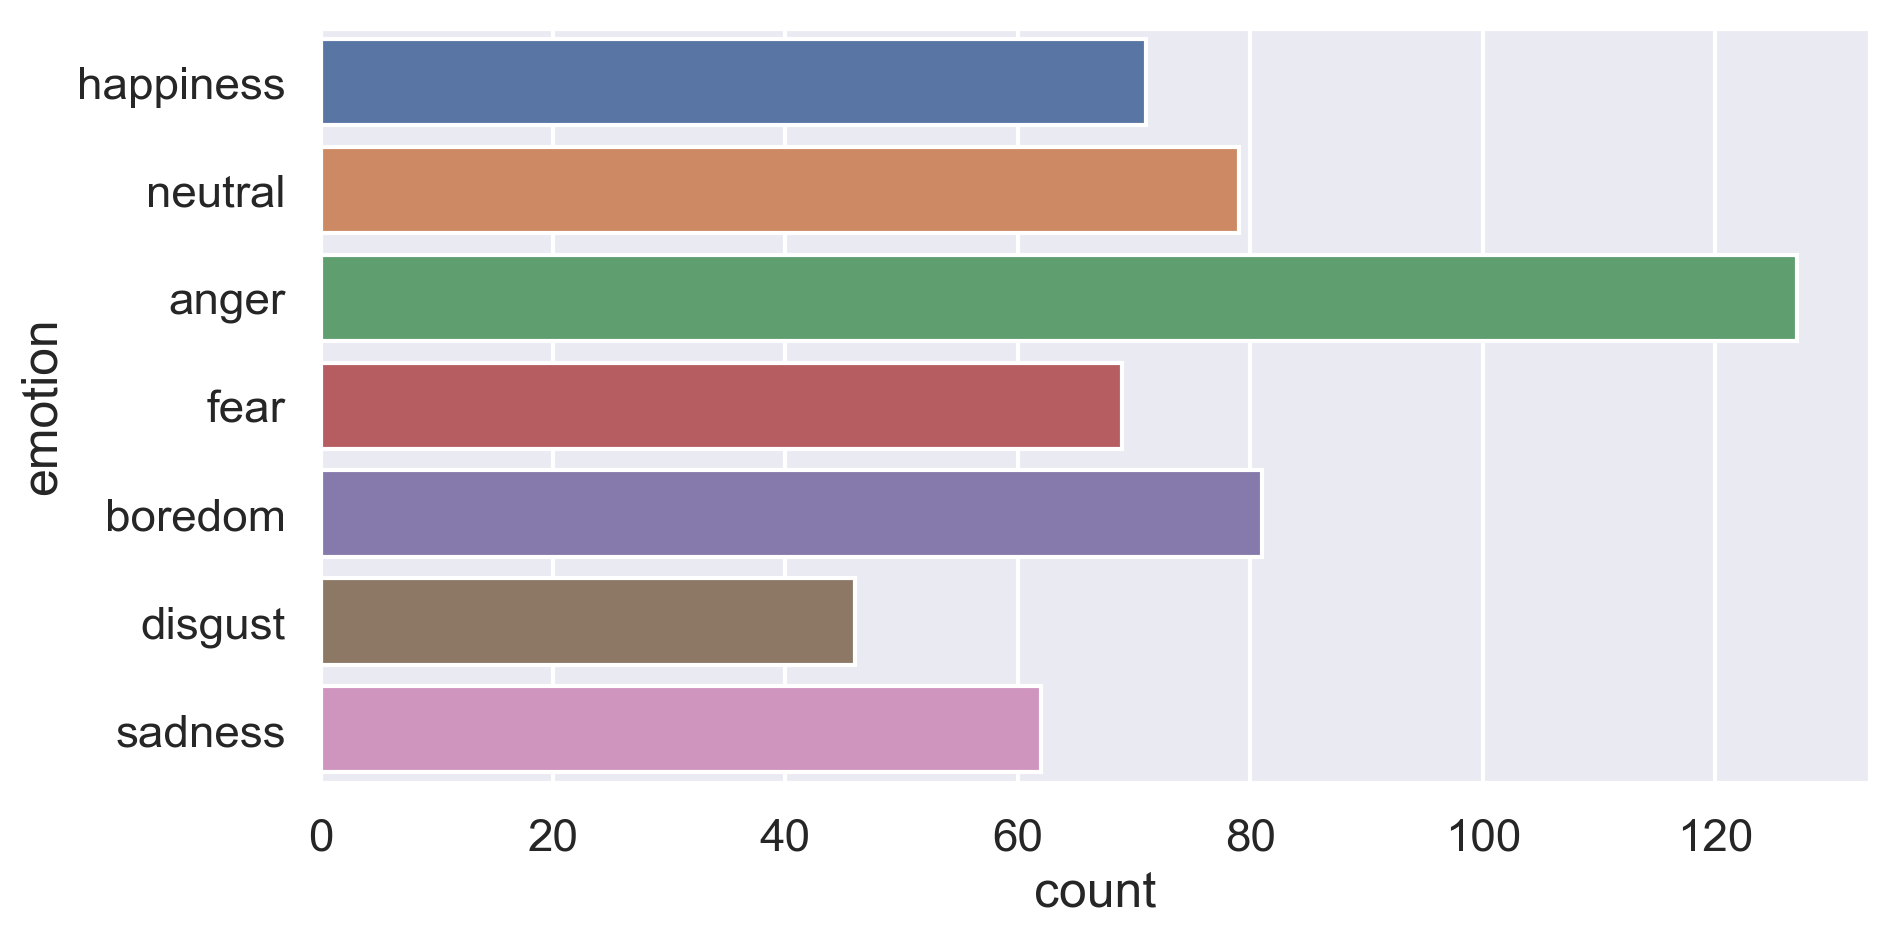

In [4]:
plt.figure(figsize=(10,5),dpi=200)
sns.countplot(y='emotion',data=df[df.wav_available])

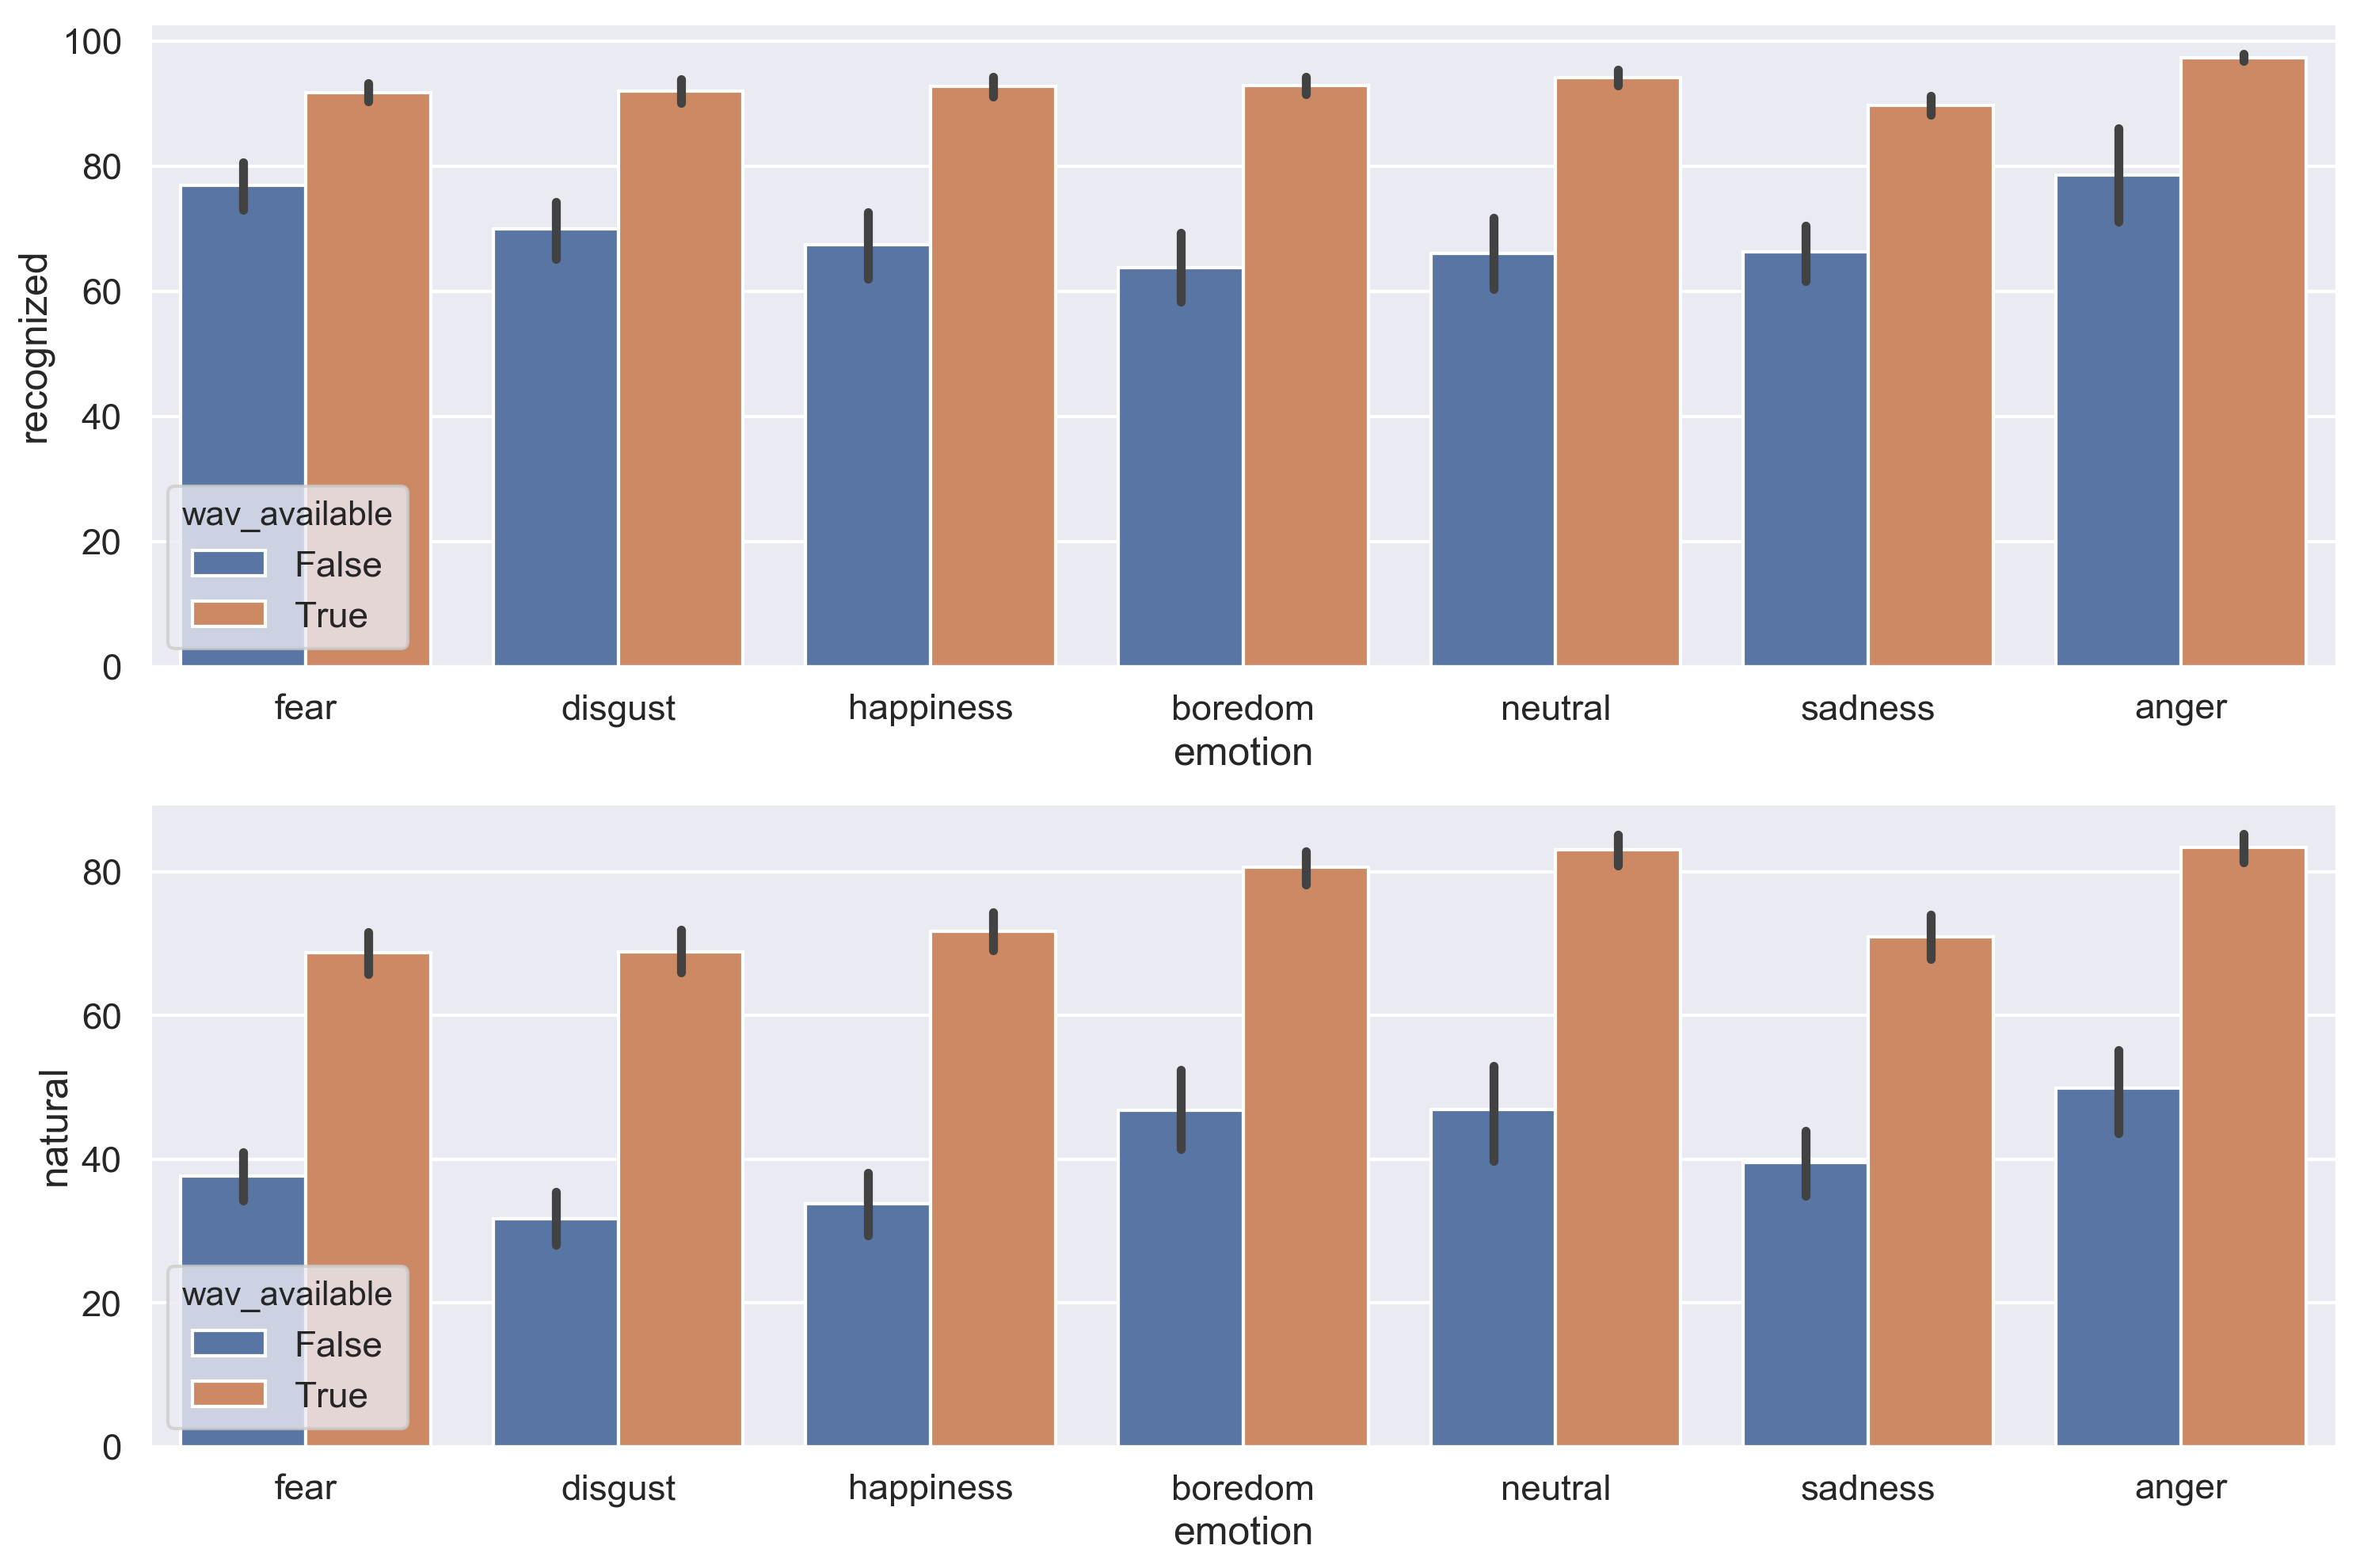

In [5]:
fig,ax = plt.subplots(ncols=1,nrows=2,figsize=(15,10),dpi=200)
sns.barplot(x='emotion',y='recognized',hue='wav_available',data=df,ax=ax[0])
sns.barplot(x='emotion',y='natural',hue='wav_available',data=df,ax=ax[1])
plt.tight_layout()

# EDA - features

/Users/flemming/miniconda3/envs/affect_recognition/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/flemming/miniconda3/envs/affect_recognition/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/flemming/miniconda3/envs/affect_recognition/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/flemming/miniconda3/envs/affect_recognition/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/flemming/miniconda3/envs/affect_recognition/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boo

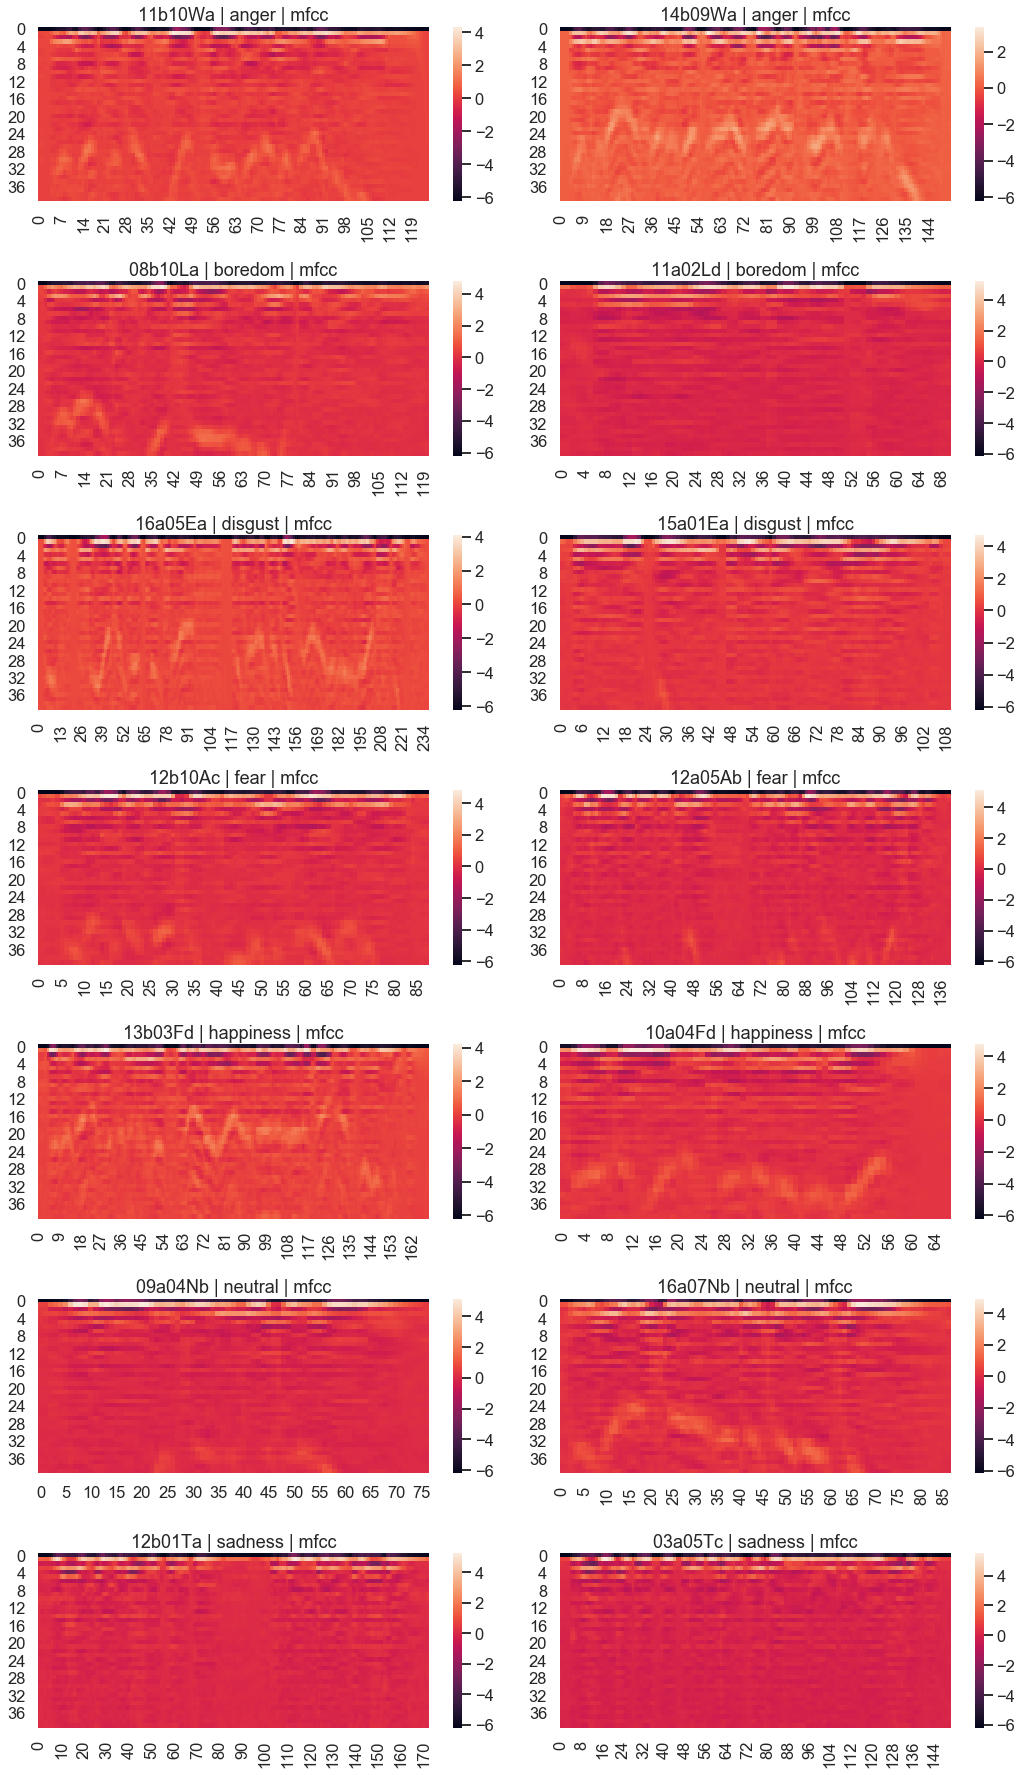

In [58]:
fig,ax = plt.subplots(ncols=2,nrows=7,figsize=(15,25))
df_wav = df[df.wav_available]
for i,emo in enumerate(np.unique(df.emotion.values)):
    df_emo = df_wav[df.emotion == emo].sample(2)
    for index,row in df_emo.iterrows():
        signal,fs = librosa.load('./EmoDB/wav/%s.wav' %index)
        mfcc = librosa.feature.mfcc(y=signal,sr=fs,n_mfcc=40)
        mfcc = (mfcc-np.mean(mfcc,axis=0)) / np.std(mfcc,axis=0)
        sns.heatmap(mfcc,ax=ax[i][df_emo.index.get_loc(index)])
        ax[i][df_emo.index.get_loc(index)].set_title('%s | %s | %s'%(index,emo,'mfcc'))
plt.tight_layout()

/Users/flemming/miniconda3/envs/affect_recognition/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


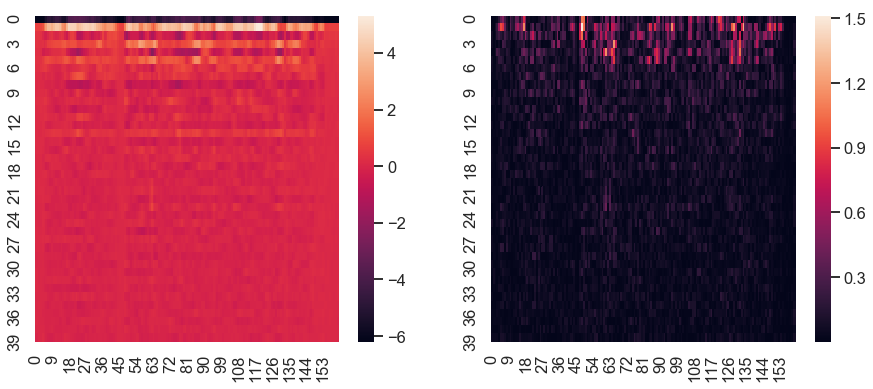

In [59]:
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(15,6))

df_emo = df_wav[df.emotion == emo].sample(2)

signal,fs = librosa.load('./EmoDB/wav/%s.wav' %df_emo.index[0])
mfcc = librosa.feature.mfcc(y=signal,sr=fs,n_mfcc=40)
mfcc = (mfcc-np.mean(mfcc,axis=0)) / np.std(mfcc,axis=0)

feat_dict = loadmat('./EmoDB/wav/%s_features.mat' %df_emo.index[0])
sns.heatmap(mfcc,ax=ax[0])
sns.heatmap(np.abs(np.gradient(mfcc,axis=1,edge_order=2)),ax=ax[1])

def abs_grad(x, axis=1):
    return np.abs(np.gradient(x,axis=axis,edge_order=2))

In [86]:
from scipy.stats import skew,kurtosis

df_wav = df[df.wav_available]
for x in tqdm(df_wav.index.values):
    signal,fs = librosa.load('./EmoDB/wav/%s.wav' %x)
    mfcc = librosa.feature.mfcc(y=signal,sr=fs,n_mfcc=20)
    # mfcc = (mfcc-np.mean(mfcc,axis=0)) / np.std(mfcc,axis=0)
    
    mfcc_mean = np.mean(mfcc,axis=1)
    mfcc_median = np.median(mfcc,axis=1)
    mfcc_var = np.var(mfcc,axis=1)
    
    mfcc_grad = abs_grad(mfcc,axis=1)
    mfcc_mean_grad = np.mean(mfcc_grad,axis=1)
    mfcc_var_grad = np.var(mfcc_grad,axis=1)
    for i in range(20):
        df_wav.at[x,'mfcc_mean_%i'%i] = mfcc_mean[i]
        df_wav.at[x,'mfcc_median_%i'%i] = mfcc_median[i]
        df_wav.at[x,'mfcc_var_%i'%i] = mfcc_var[i]
        df_wav.at[x,'mfcc_mean_grad_%i'%i] = mfcc_mean_grad[i]
        df_wav.at[x,'mfcc_var_grad_%i'%i] = mfcc_var_grad[i]

/Users/flemming/miniconda3/envs/affect_recognition/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/flemming/miniconda3/envs/affect_recognition/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [92]:
df_features = df_wav.drop(['sex','age','natural','recognized','wav_available'],axis=1).set_index('emotion')
df_features = df_features.dropna(axis=0)
df_features.head()

,mfcc_mean_0,mfcc_median_0,mfcc_var_0,mfcc_mean_grad_0,mfcc_var_grad_0,mfcc_mean_1,mfcc_median_1,mfcc_var_1,mfcc_mean_grad_1,mfcc_var_grad_1,...,mfcc_mean_18,mfcc_median_18,mfcc_var_18,mfcc_mean_grad_18,mfcc_var_grad_18,mfcc_mean_19,mfcc_median_19,mfcc_var_19,mfcc_mean_grad_19,mfcc_var_grad_19
emotion,,,,,,,,,,,,,,,,,,,,,
happiness,-282.091660,-257.075189,15175.097881,41.512688,1384.363348,115.890647,120.617978,3148.081050,18.187666,160.701784,...,-0.488676,0.099595,71.356723,3.556048,8.615772,-3.216940,-2.957462,40.883823,2.790660,3.669334
neutral,-266.735584,-236.140294,17531.685452,38.195689,1206.407267,142.883696,165.576228,4057.499520,19.528967,351.067377,...,3.640300,3.991886,58.181358,2.755276,4.978722,-1.120479,0.412753,46.784743,3.003510,4.605372
anger,-231.606219,-201.983250,17724.852214,46.315386,1593.178986,92.590414,91.284422,2557.245931,15.862898,196.371442,...,-4.526877,-4.147133,45.194778,2.742361,5.760729,-6.291707,-4.983669,73.218182,3.932573,8.774396
fear,-240.321648,-205.752854,14150.701625,34.391358,1055.233557,97.674955,110.914730,2387.100265,16.063904,189.306565,...,-8.090889,-7.996850,175.647756,4.040969,8.880577,-0.134950,1.201369,82.472071,3.921742,13.282829
happiness,-238.721449,-194.928835,23498.572804,31.913805,1063.241640,85.583634,92.363868,3116.650439,13.854893,212.366100,...,-3.790292,-2.610912,94.050872,3.123156,7.515017,0.521527,1.138984,32.549460,2.474215,4.313990


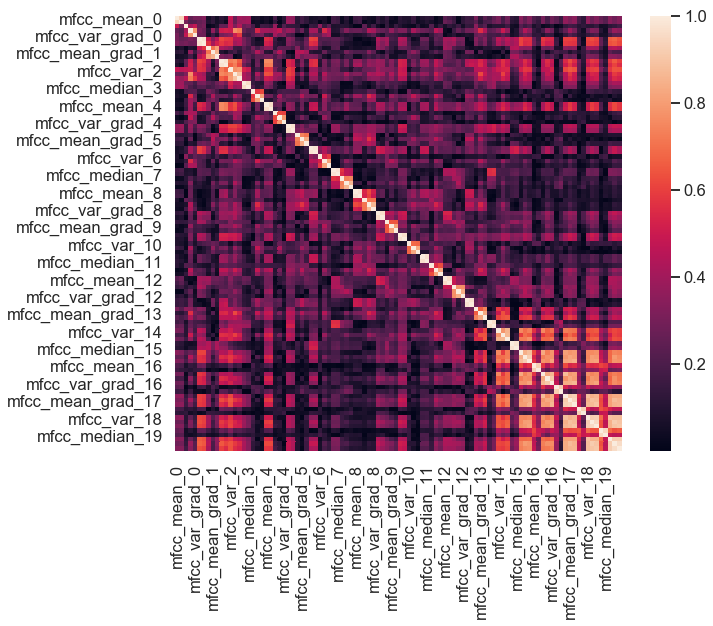

In [93]:
plt.figure(figsize=(10,8))
sns.heatmap(np.abs(df_features.corr()))

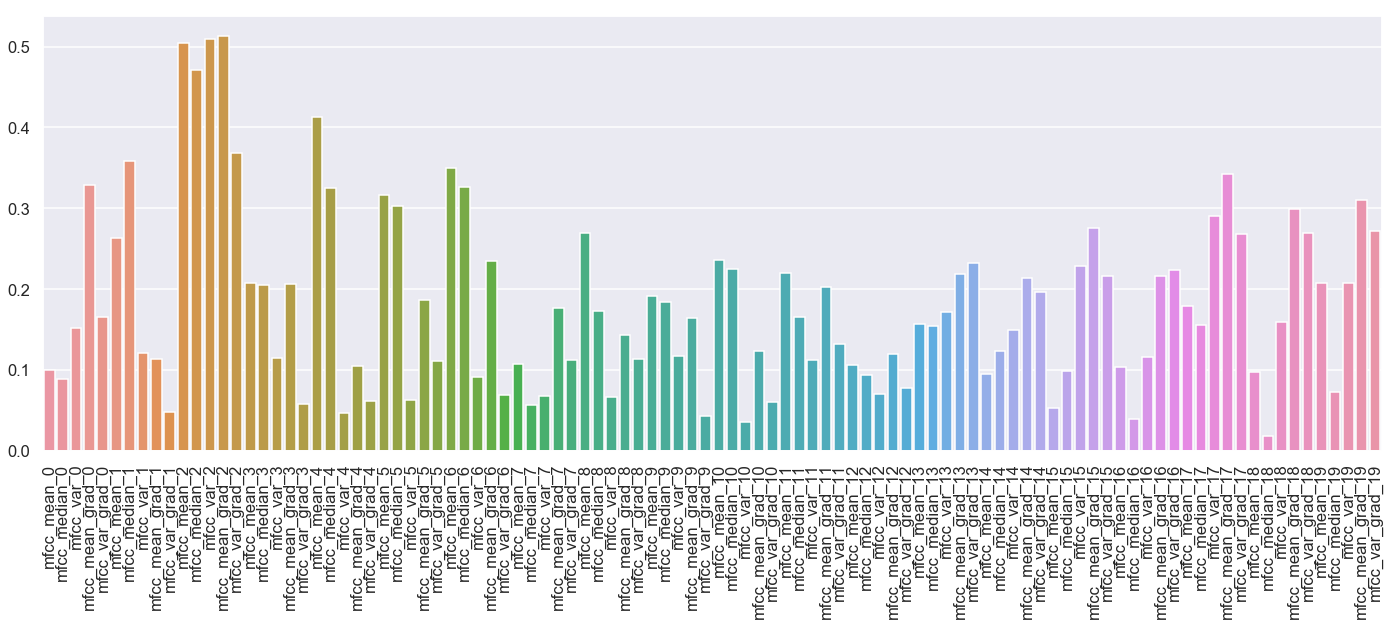

In [94]:
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectKBest

X,y = df_features.values,df_features.index.values

feature_score = mutual_info_classif(X,y)
fig, ax = plt.subplots(figsize=(24,8))
sns.barplot(x=df_features.columns,y=feature_score,ax=ax)

_ = [label.set_rotation('vertical') for label in ax.get_xticklabels()]

Text(0,0.5,'mfcc_mean_grad_2')

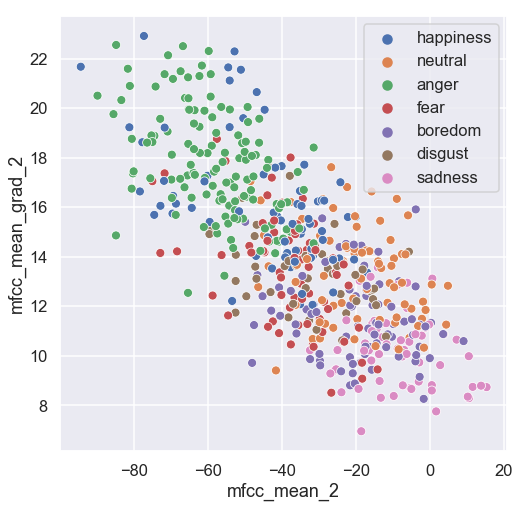

In [91]:
selector = SelectKBest(f_classif, k=2)
kbest = selector.fit_transform(X, y)
kbest_names = df_features.columns.values[selector.get_support()]
plt.figure(figsize=(8,8))
sns.scatterplot(x=kbest[:,0],y=kbest[:,1],hue=y)
plt.xlabel(kbest_names[0])
plt.ylabel(kbest_names[1])

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score

all_classes = list(set(df_features.index.values))
y = [all_classes.index(i) for i in df_features.index.values]

clf = LogisticRegression()
# clf = RandomForestClassifier(n_estimators=100, max_features=10)
scores = []
for i in range(20):
    scores = list(cross_val_score(clf, X, y, cv=5))
    
print("Accuracy: %0.2f (+/- %0.2f)" % (np.mean(scores), np.mean(np.std(scores) * 2)))

Accuracy: 0.70 (+/- 0.08)


0.7232704402515723


Text(213.167,0.5,'True class')

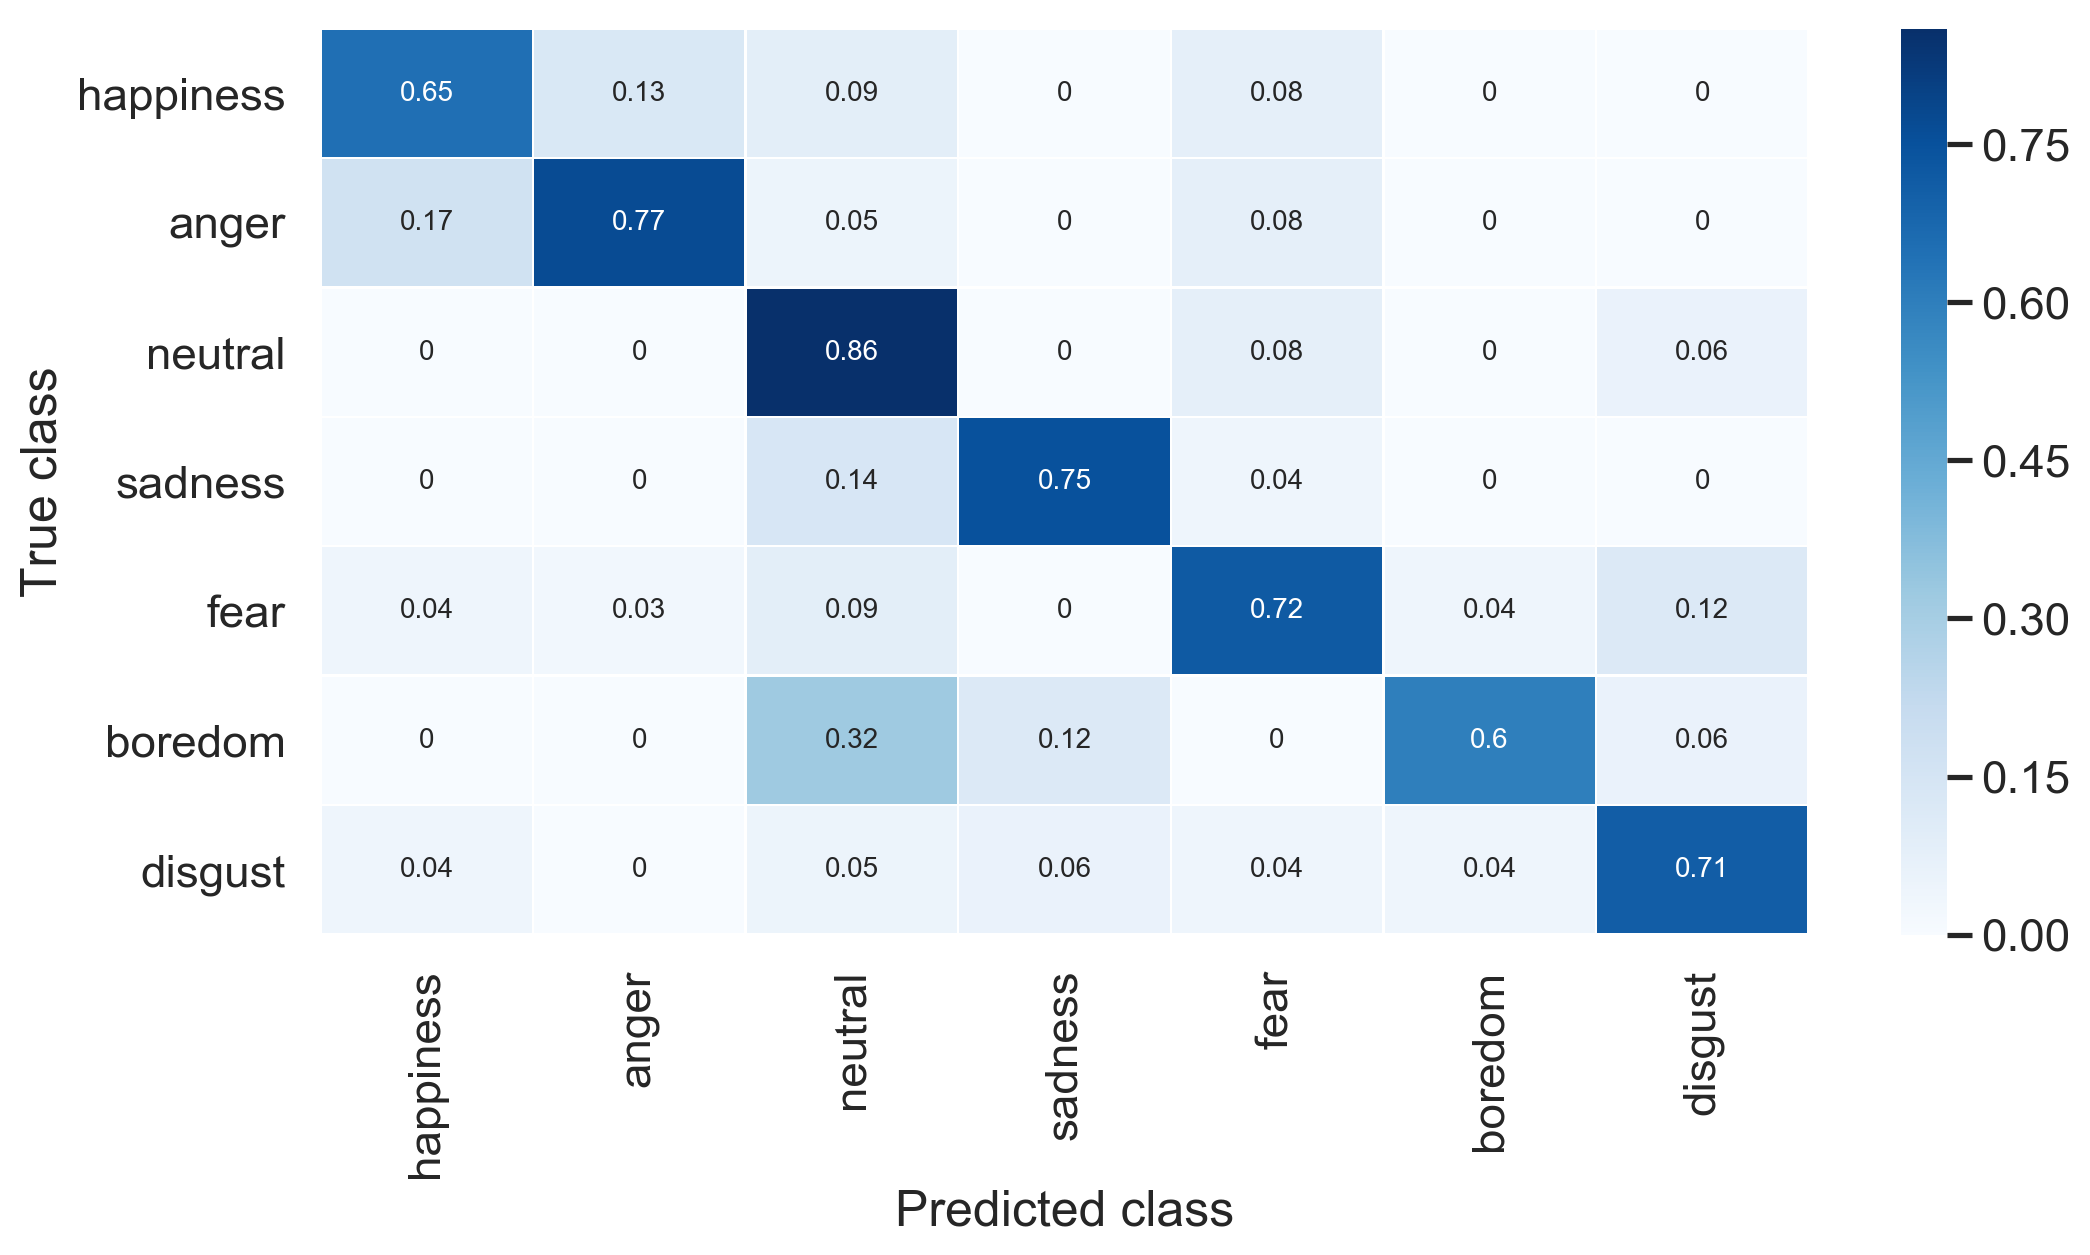

In [173]:
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(clf.score(X_test, y_test))
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat = np.round((conf_mat / np.sum(conf_mat, axis=1)),2)


fig, ax = plt.subplots(figsize=(12,6),dpi=200)
sns.heatmap(conf_mat, cmap='Blues', annot=True, linewidths=.5, ax=ax)

ax.set_xticklabels(all_classes)
_ = [label.set_rotation('vertical') for label in ax.get_xticklabels()]
ax.set_xlabel('Predicted class')
ax.set_yticklabels(all_classes)
_ = [label.set_rotation('horizontal') for label in ax.get_yticklabels()]
ax.set_ylabel('True class')

In [174]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=all_classes))

             precision    recall  f1-score   support

  happiness       0.71      0.65      0.68        23
      anger       0.83      0.77      0.80        31
    neutral       0.54      0.86      0.67        22
    sadness       0.80      0.75      0.77        16
       fear       0.69      0.72      0.71        25
    boredom       0.88      0.60      0.71        25
    disgust       0.75      0.71      0.73        17

avg / total       0.75      0.72      0.73       159

